# Set-up

In [1]:
import os
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib import colors
from matplotlib import ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cmcrameri import cm

import matplotlib_functions
from treeconfigparser import TreeConfigParser

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import models.reg as rg
import models.seg as sg
from data.Data import Data
from include.loss import pixel_weighted_cross_entropy
from include import generators

matplotlib_functions.setMatplotlibParam()
plt.viridis()

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/res"

Segmentation Models: using `keras` framework.


In [11]:
def get_data(name_ds: str, scaler):
    config = TreeConfigParser()
    config.readfiles(os.path.join(dir_res, name_ds, "config.cfg"))
    shuffle_indices = np.fromfile(os.path.join(dir_res, name_ds, "shuffle_indices.bin")).astype(np.int64)
    data = Data(config, shuffle_indices)
    data.prepare_input(scaler)
    data.prepare_output()
    return data

In [12]:
def get_model(path_w: str):
    model = keras.models.load_model(os.path.join(path_w, "weights_cp_best.h5"), compile=False)
    model.compile('adam', loss=pixel_weighted_cross_entropy)    
    return model

def get_scaler(path_w: str):
    scaler = joblib.load(os.path.join(path_w, "scaler.save"))
    return scaler

# Synthetic datasets draw (figure 1)

In [3]:
ds = xr.open_dataset("/libre/dumontj/coco2/dl-input/LS_pPGIBPW/dataset.nc")

In [43]:
ds

<xarray.Dataset>
Dimensions:         (idx_img: 38836, dir_crop: 4, y: 160, x: 160, hour_prec: 6,
                     hour: 24)
Coordinates:
  * idx_img         (idx_img) int32 0 1 2 3 4 ... 38831 38832 38833 38834 38835
  * y               (y) int32 0 1 2 3 4 5 6 7 ... 153 154 155 156 157 158 159
  * x               (x) int32 0 1 2 3 4 5 6 7 ... 153 154 155 156 157 158 159
Dimensions without coordinates: dir_crop, hour_prec, hour
Data variables:
    folder          (idx_img) object ...
    ppresence       (idx_img) bool ...
    index_crop      (idx_img) bool ...
    time            (idx_img) datetime64[ns] ...
    shape_cropping  (idx_img, dir_crop) int32 ...
    emiss           (idx_img, hour_prec) float32 ...
    pixels_plume    (idx_img, y, x) float32 ...
    trace           (idx_img, y, x) float32 ...
    v_hour          (idx_img) int64 ...
    v_oneHotHour    (idx_img, hour) int32 ...
    xco2            (idx_img, y, x) float32 ...
Attributes:
    description:  Anthropogenic XCO2 plume related data
    N_p_crop:     0
    N_n_crop:     0
    thresh_type:  pure
    thresh_val:   0.05
    N_img:        38836

In [149]:
def add_left_colorbar(contour, ax):
    cax = ax.inset_axes((-0.07, 0, 0.05, 1))
    cax.grid(False)
    cbar = plt.colorbar(contour, cax=cax)
    cax.yaxis.set_ticks_position("left")
    cbar.locator = ticker.MaxNLocator(nbins=6)
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize="7")
    cbar.set_ticks([float(item) for item in cbar.get_ticks()])
    cbar.set_ticklabels(["{0:.1f}".format(i) for i in cbar.get_ticks()])    

In [106]:
def add_right_colorbar(contour,ax):
    cax = ax.inset_axes((1.02, 0, 0.05, 1))
    cax.grid(False)
    cbar = plt.colorbar(contour, cax, orientation="vertical", label="XCO2 [ppmv]")
    cbar.locator = ticker.MaxNLocator(nbins=6)
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize="7")
    cbar.set_ticks([float(item) for item in cbar.get_ticks()])
    cbar.set_ticklabels(["{0:.0f}".format(i) for i in cbar.get_ticks()])

### Berlin

In [141]:
idx_img_ber = np.random.choice(ds.sel(idx_img=ds["folder"]=="smart_pBer_nBBer")["idx_img"].values)
da_idx_ber = ds.sel(idx_img=idx_img_ber)

In [98]:
idx_img_ber = 35824
da_idx_ber = ds.sel(idx_img=idx_img_ber)

### Paris

In [102]:
idx_img_par = np.random.choice(ds.sel(idx_img=ds["folder"]=="lsce_pPGI_nBBO")["idx_img"].values)
da_idx_par = ds.sel(idx_img=idx_img_par)

In [104]:
idx_img_par = 29564
da_idx_par = ds.sel(idx_img=idx_img_par)

### Janswchälde

In [131]:
idx_img_jan = np.random.choice(ds.sel(idx_img=ds["folder"]=="smart_pJan_nBJan")["idx_img"].values)
da_idx_jan = ds.sel(idx_img=idx_img_jan)

In [136]:
idx_img_jan = 10056
da_idx_jan = ds.sel(idx_img=idx_img_jan)

10056

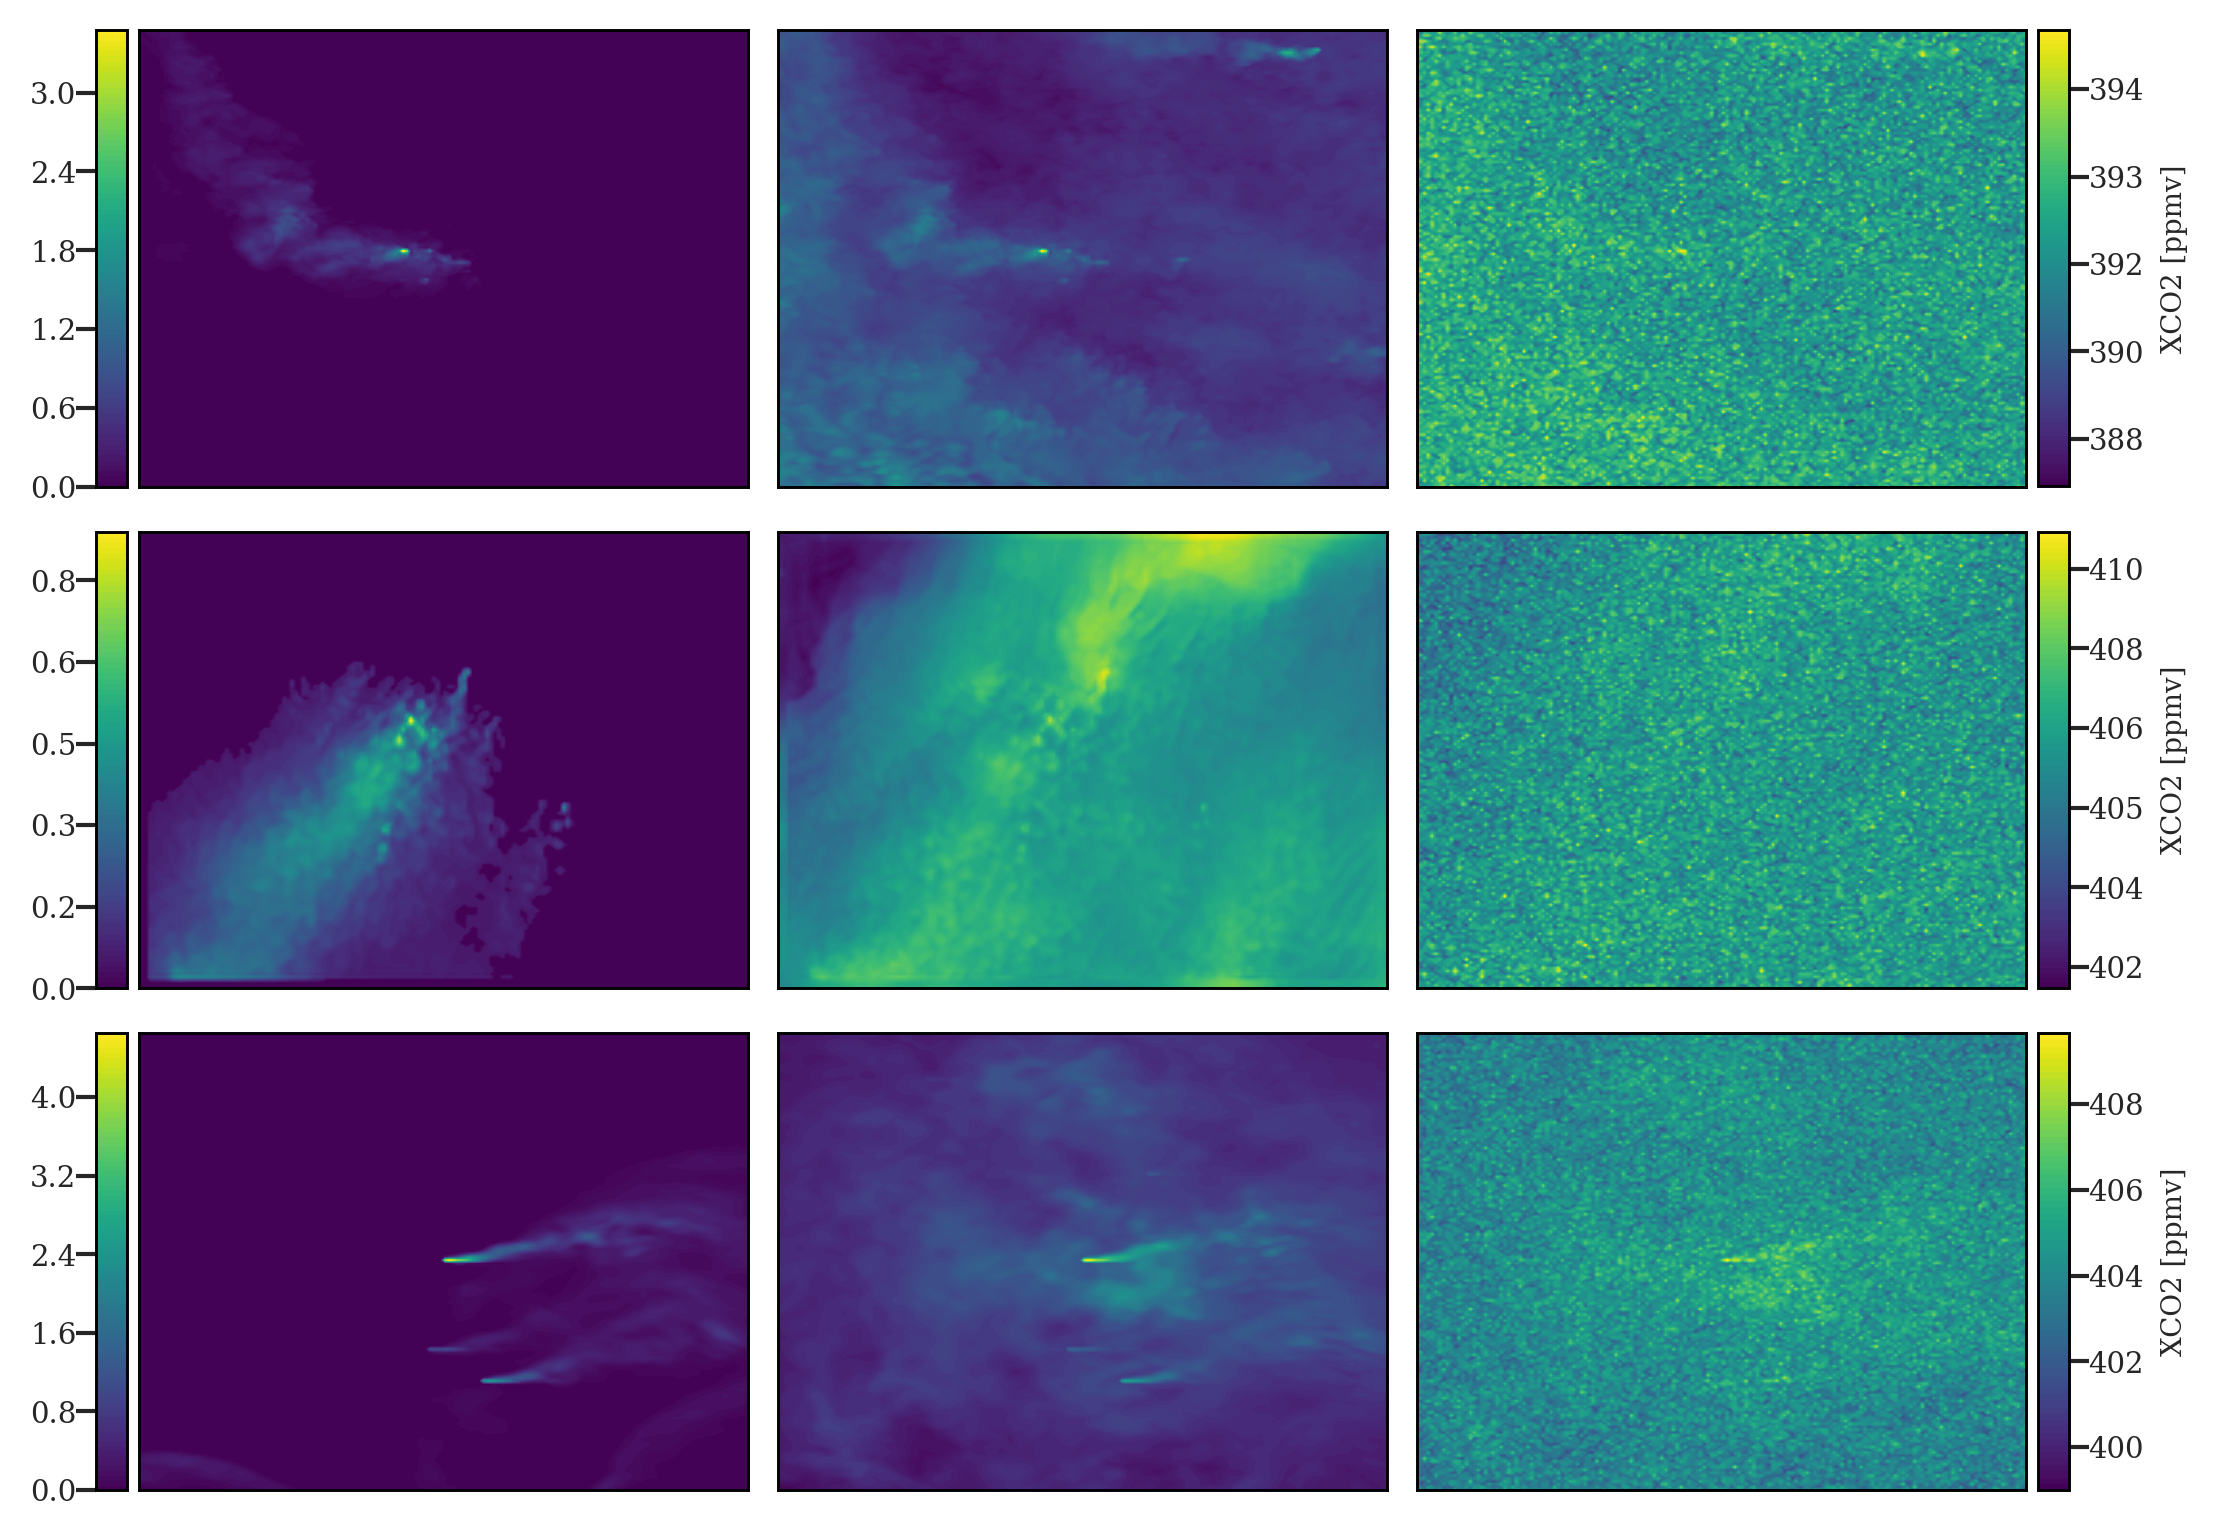

In [151]:
axs = matplotlib_functions.set_figure_axs(3,3, pad_w_int=0.1, pad_h_int = 0.15, pad_w_ext_left=0.4, pad_w_ext_right=0.6)

contour_0 = axs[0].contourf(da_idx_ber["trace"],cmap="viridis", levels=100)
contour_1 = axs[1].contourf(da_idx_ber["xco2"],cmap="viridis", levels=100)
contour_2 = axs[2].contourf(da_idx_ber["xco2"]+np.random.normal(size=da_idx_ber["xco2"].shape),cmap="viridis", levels=100)

contour_3 = axs[3].contourf(da_idx_par["trace"],cmap="viridis", levels=100)
contour_4 = axs[4].contourf(da_idx_par["xco2"],cmap="viridis", levels=100)
contour_5 = axs[5].contourf(da_idx_par["xco2"]+np.random.normal(size=da_idx_par["xco2"].shape),cmap="viridis", levels=100)

contour_6 = axs[6].contourf(da_idx_jan["trace"],cmap="viridis", levels=100)
contour_7 = axs[7].contourf(da_idx_jan["xco2"],cmap="viridis", levels=100)
contour_8 = axs[8].contourf(da_idx_jan["xco2"]+np.random.normal(size=da_idx_jan["xco2"].shape),cmap="viridis", levels=100)

add_right_colorbar(contour_2,axs[2])
add_right_colorbar(contour_5,axs[5])
add_right_colorbar(contour_8,axs[8])

add_left_colorbar(contour_0, axs[0])
add_left_colorbar(contour_3, axs[3])
add_left_colorbar(contour_6, axs[6])

for idx in range(9):
    axs[idx].set_xticklabels([])
    axs[idx].set_yticklabels([])
"""
axs[0].text(0.03, 0.93, "(a)", transform = axs[0].transAxes, color="white")
axs[1].text(0.03, 0.93, "(b)", transform = axs[1].transAxes, color="white")
axs[2].text(0.03, 0.93, "(c)", transform = axs[2].transAxes, color="white")
"""

plt.savefig (f"paper_creation_input_{idx_img_ber}_{idx_img_par}_{idx_img_jan}.png")

# Data augmentation (figure 2)

In [2]:
dir_emi_scen = os.path.join(coco2_data_config.scen_data_dir, "smart_pLip_nBLip")
ds = xr.open_dataset(os.path.join(dir_emi_scen, "dataset.nc"))

In [3]:
xco2 = ds.xco2.values
xco2 = np.expand_dims(xco2, -1)
trace = ds.put_trace.values
trace = np.expand_dims(trace, -1)

In [12]:
config = TreeConfigParser()
config.readfiles(os.path.join("cfg", "light_DA.cfg"))
generator = generators.Generator(config)
t = np.random.choice(2000)
generator.flow([xco2[t:t+1]], trace[t:t+1])

In [36]:
matplotlib_functions.setMatplotlibParam()
plt.viridis()

<Figure size 3300x2100 with 0 Axes>

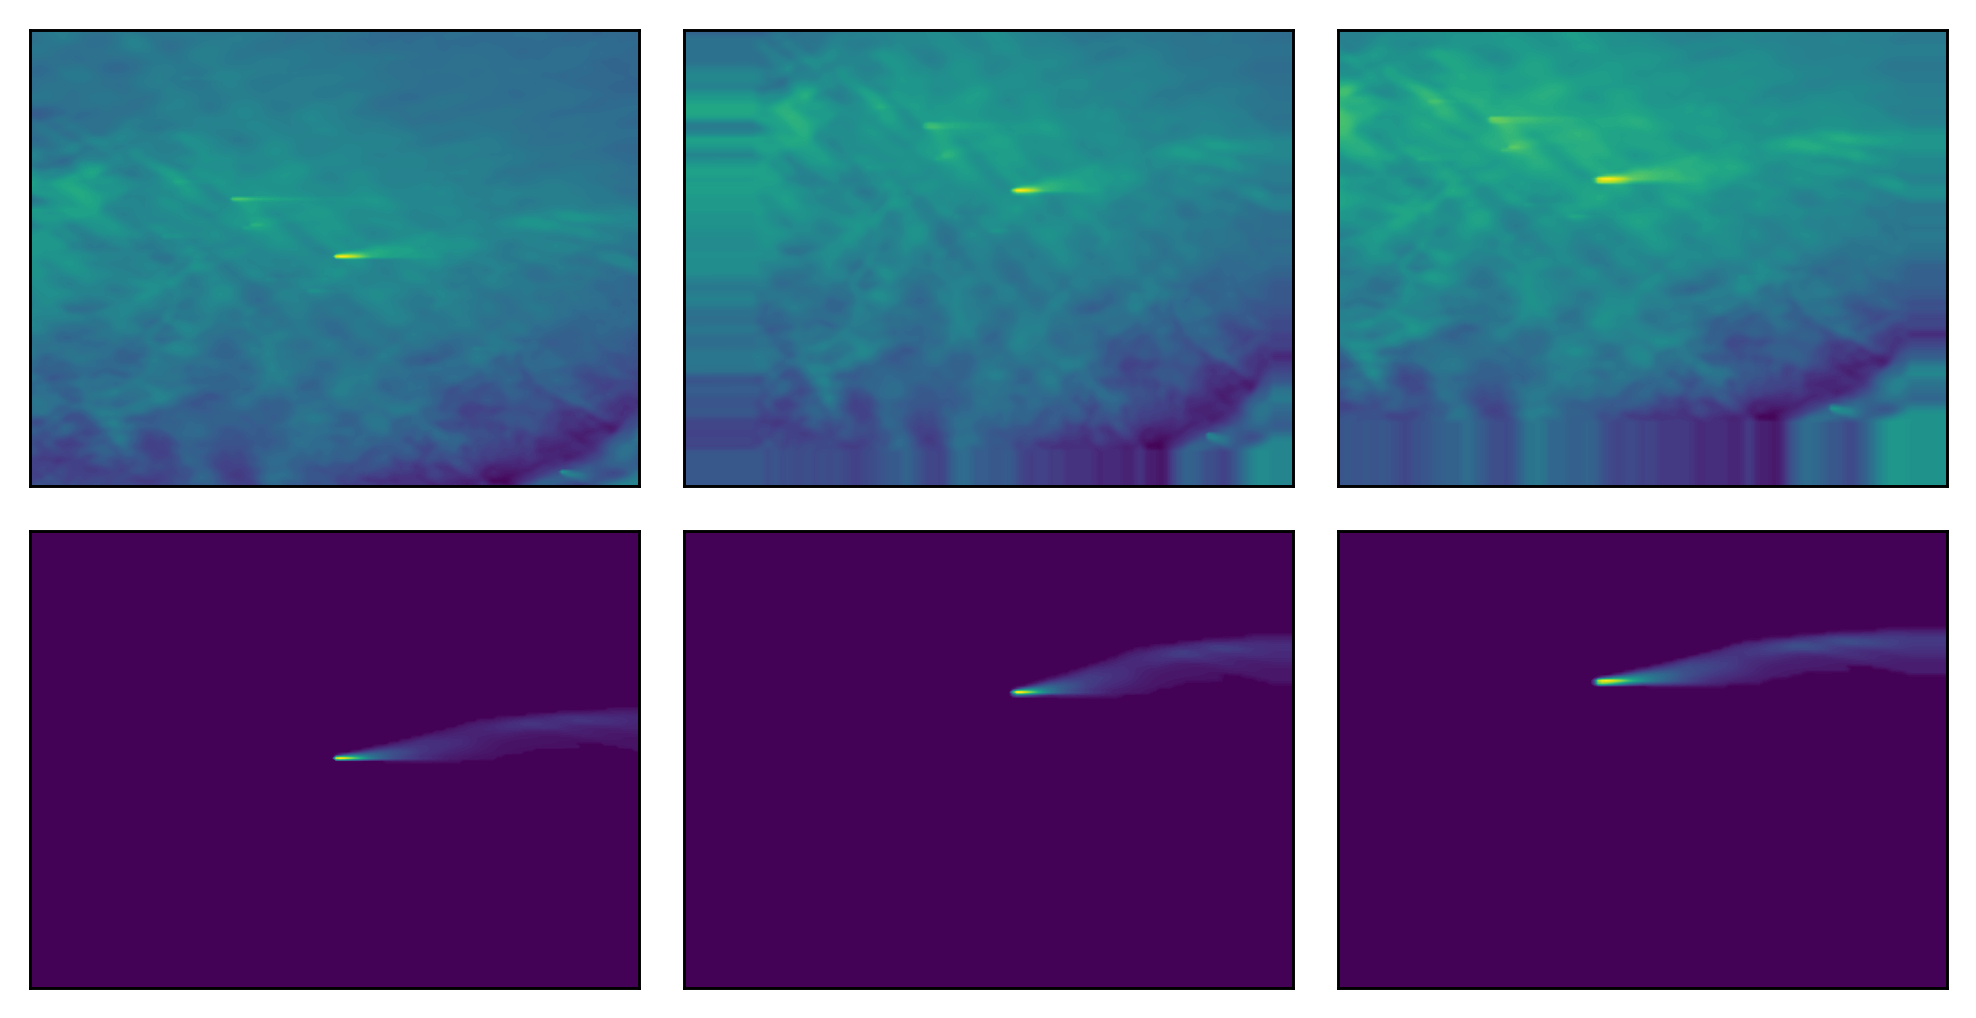

In [50]:
axs = matplotlib_functions.set_figure_axs(2,3, pad_w_ext_left=0.1, pad_w_ext_right=0.1, 
                                          pad_w_int=0.15, pad_h_ext=0.2, pad_h_int=0.15)
axs[0].contourf(xco2[t,:,:,0], levels=100)
axs[3].contourf(trace[t,:,:,0], levels=100)
for i in range(0,2):
    x,y = generator.next()
    image = x[0]
    label = y[0]
    axs[1+i].contourf(image[:,:,0], levels=100)
    axs[4+i].contourf(label[:,:,0], levels=100)
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.savefig(os.path.join("fig", f"paper_data_generation_light.png"))    

# Plume segmentation purpose (figure 3)

# Pixel weighted justification (figure 4)

# U-net (figure 5)

# PGIBPP on PGIBPP (figure 6-7-8)

In [23]:
dataset = "chaintest_20220712-134109/test1"
weights = "chaintest_20220712-134109/test1"

In [5]:
config_weights = TreeConfigParser()
config_weights.readfiles(os.path.join(dir_res, weights, "config.cfg"))
weights_ds = config_weights.get("data.directory.name")
dir_fig = os.path.join("eval/fig/seg", weights_ds)
if not os.path.exists(dir_fig):
    os.makedirs(dir_fig)

In [13]:
model = get_model(os.path.join(dir_res, weights))
scaler = get_scaler(os.path.join(dir_res, weights))
data = get_data(os.path.join(dir_res, dataset), scaler)

mean, var xco2 402.0255 12.423682
data.inp.train.shape[0] (6874, 160, 160, 1)
data.out.train.shape (6874, 160, 160, 1)
y valid mean 0.12781126928624978


## U-net application (figure 6)

## Histogram relative error (figure 7)

## U-net application (bad) (figure 8)

# PGIPP on B (figure 9-10)

In [23]:
dataset = "seg_ber"
weights = "seg_PGIPP_DA2_3_Unet_efficient"

In [5]:
config_weights = TreeConfigParser()
config_weights.readfiles(os.path.join(dir_res, weights, "config.cfg"))
weights_ds = config_weights.get("data.directory.name")
dir_fig = os.path.join("eval/fig/seg", weights_ds)
if not os.path.exists(dir_fig):
    os.makedirs(dir_fig)

In [13]:
model = get_model(os.path.join(dir_res, weights))
scaler = get_scaler(os.path.join(dir_res, weights))
data = get_data(os.path.join(dir_res, dataset), scaler)

mean, var xco2 402.0255 12.423682
data.inp.train.shape[0] (6874, 160, 160, 1)
data.out.train.shape (6874, 160, 160, 1)
y valid mean 0.12781126928624978


## Histogram (figure 9)

## U-net application (figure 10)

## Evaluation

### Preparation

In [25]:
x_valid = tf.convert_to_tensor(data.x.valid[0], np.float32)
pred_valid = tf.convert_to_tensor(model.predict(x_valid), np.float32)
y_valid = tf.convert_to_tensor(data.y.valid, np.float32)
loss_valid = model.evaluate(x=x_valid, y=y_valid, batch_size=64)
data.y.get_trace(xr.open_dataset(data.path_dataset), data.eval_shuffler)
ds = xr.open_dataset(data.path_dataset)
xco2 = np.expand_dims(ds.xco2.values, -1)
[xco2_train, xco2_valid] = data.eval_shuffler.train_valid_split(xco2)

27/27 [==============================] - 2s 40ms/step - loss: 0.3171


In [20]:
trainData_generator = keras.preprocessing.image.ImageDataGenerator(
            rotation_range = 0,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip = False,
            vertical_flip = False,
            shear_range = 0.2,
            zoom_range = 0.2
        )
data_gen_losses = model.evaluate(trainData_generator.flow([x_valid, y_valid], batch_size=32), batch_size=64)

190/190 [==============================] - 13s 59ms/step - loss: 0.1453


In [28]:
ds_valid = ds.sel(idx_img=data.eval_shuffler.ds_inds["valid"])

### Individual losses

In [26]:
all_loss_valid = pixel_weighted_cross_entropy(y_valid, pred_valid, reduction=False)
all_loss_valid = np.mean(all_loss_valid,axis=(1,2))
n_outliers_val = int(0.01*len(all_loss_valid))
indices_with_no_outliers = np.argpartition(all_loss_valid, -n_outliers_val)[:-n_outliers_val]
indices_outliers = np.argpartition(all_loss_valid, -n_outliers_val)[-n_outliers_val:]

### Segmentation losses with respect to characteristics of the image-plume

In [32]:
df_full = pd.DataFrame({'loss': all_loss_valid,
                   'origin': ds_valid.folder.values.astype(str),
                   'time': ds_valid.v_hour.values,
                   'emiss': ds_valid.emiss.values[:,0]
                  })

In [33]:
df_no_outliers = pd.DataFrame({'loss': all_loss_valid[indices_with_no_outliers],
                   'origin': ds_valid.folder.values[indices_with_no_outliers].astype(str),
                   'time': ds_valid.v_hour.values[indices_with_no_outliers],
                   'emiss': ds_valid.emiss.values[indices_with_no_outliers,0]
                  })

In [34]:
df_outliers = pd.DataFrame({'loss': all_loss_valid[indices_outliers],
                   'origin': ds_valid.folder.values[indices_outliers].astype(str),
                   'time': ds_valid.v_hour.values[indices_outliers],
                   'emiss': ds_valid.emiss.values[indices_outliers,0]
                  })

In [35]:
df = df_no_outliers

In [289]:
df["origin"] = np.where(df["origin"].values == "smart_pBox_nBBox", "Boxberg (PP)", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "smart_pLip_nBLip", "Lippendorf (PP)", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "smart_pJan_nBJan", "Janschwälde (PP)", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "lsce_pPG_nBBO", "Grand Paris", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "lsce_pPGI_nBBO", "Grand Paris + IDF", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "smart_pBer_nBBer", "Berlin", df["origin"].values)

In [290]:
df_no_outliers

loss  origin  time      emiss
0     0.229644  Berlin    20   9.198209
1     0.213317  Berlin    22  14.318530
2     0.100689  Berlin    21  19.875299
3     0.218539  Berlin     9  28.068810
4     0.117060  Berlin     3  12.217040
...        ...     ...   ...        ...
1697  1.616721  Berlin     5  20.491159
1698  1.620256  Berlin    11  12.236560
1699  1.602987  Berlin     3   8.534194
1700  1.661505  Berlin    23   7.831539
1701  1.663273  Berlin     3   5.893612

[1702 rows x 4 columns]

[None, None]

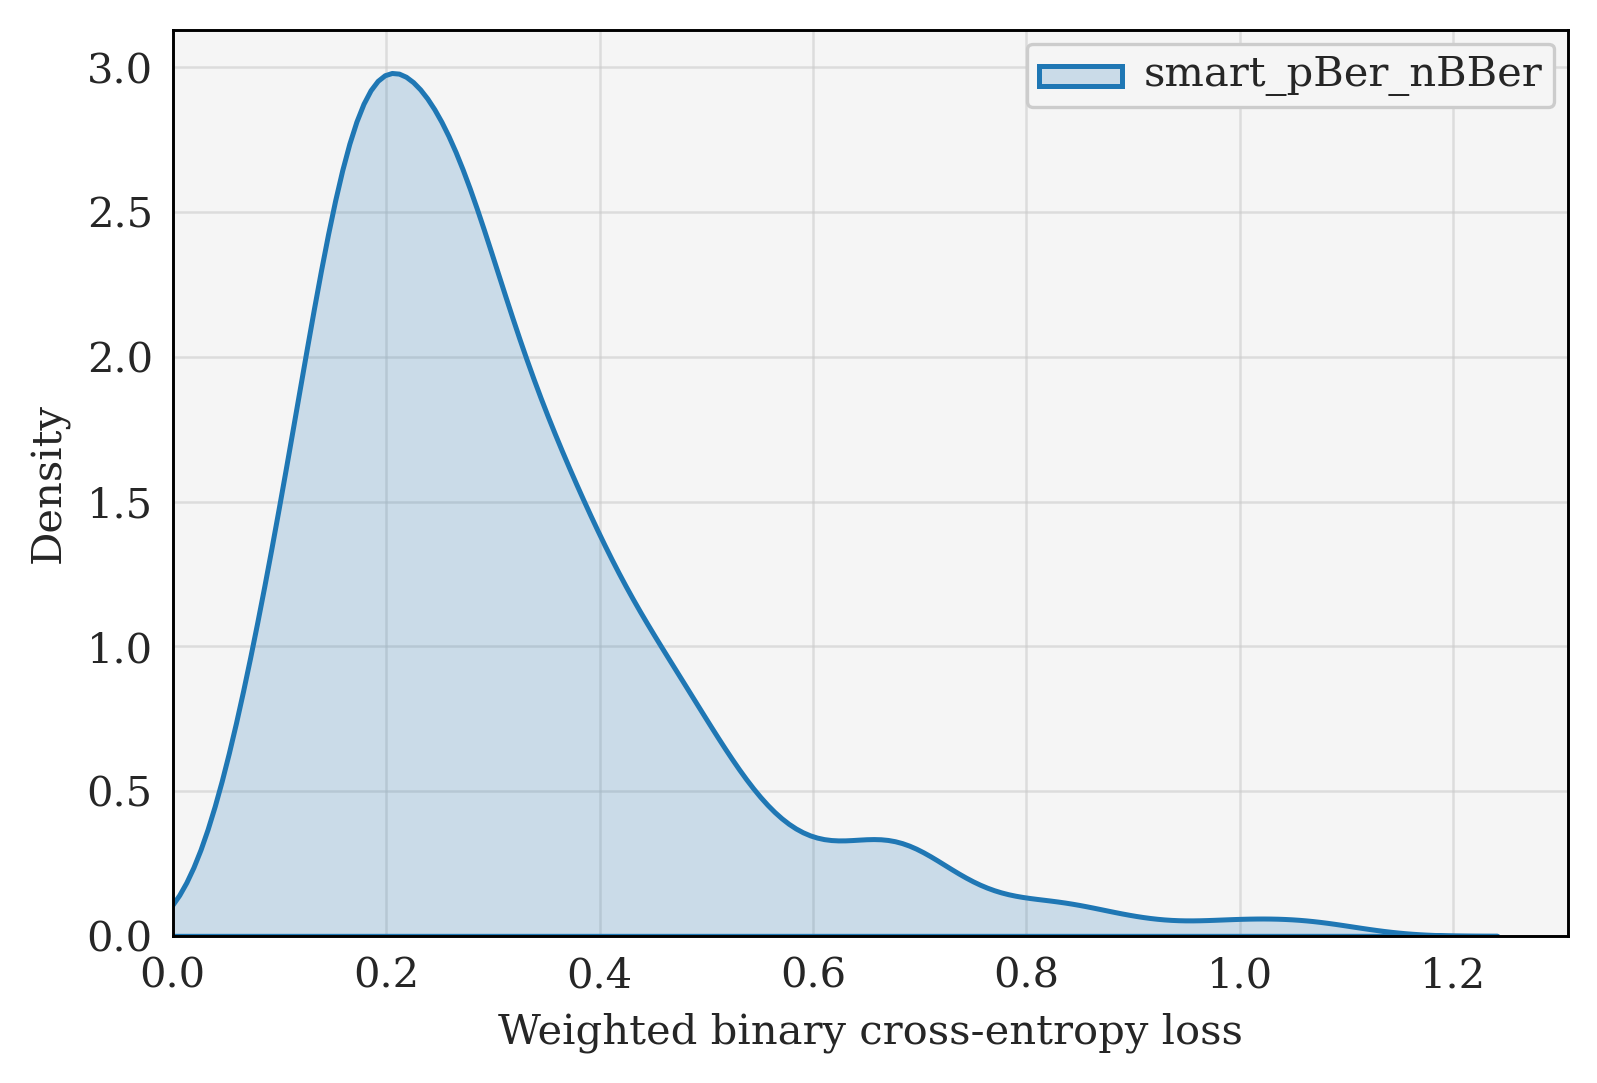

In [36]:
ax = sns.kdeplot(
    data=df,
    x="loss",
    hue="origin",
    common_norm=False,
    fill=True,
    lw=1.2,
    alpha=0.2,
    #palette=["firebrick", "orangered", "darkolivegreen", "dodgerblue", "darkcyan"],
    #hue_order = ["Grand Paris + IDF", "Grand Paris", "Lippendorf (PP)", "Boxberg (PP)", "Janschwälde (PP)"],
)
plt.xlim(xmin=0)
plt.xlabel("Weighted binary cross-entropy loss", size=10)
plt.ylabel("Density", size=10)
plt.xticks(size=10)
plt.yticks(size=10)
ax.legend_.set_title(None)
plt.setp(ax.get_legend().get_texts(), fontsize='10')
plt.setp(ax.get_legend().get_title(), fontsize='12')
#plt.savefig(os.path.join(dir_fig, f"paper_seg_w{weights_ds}_ds{data.name_dataset}_hist_origin.png"))

In [39]:
df["emiss"] = pd.qcut(df["emiss"], q=4, precision=2)

[None, None]

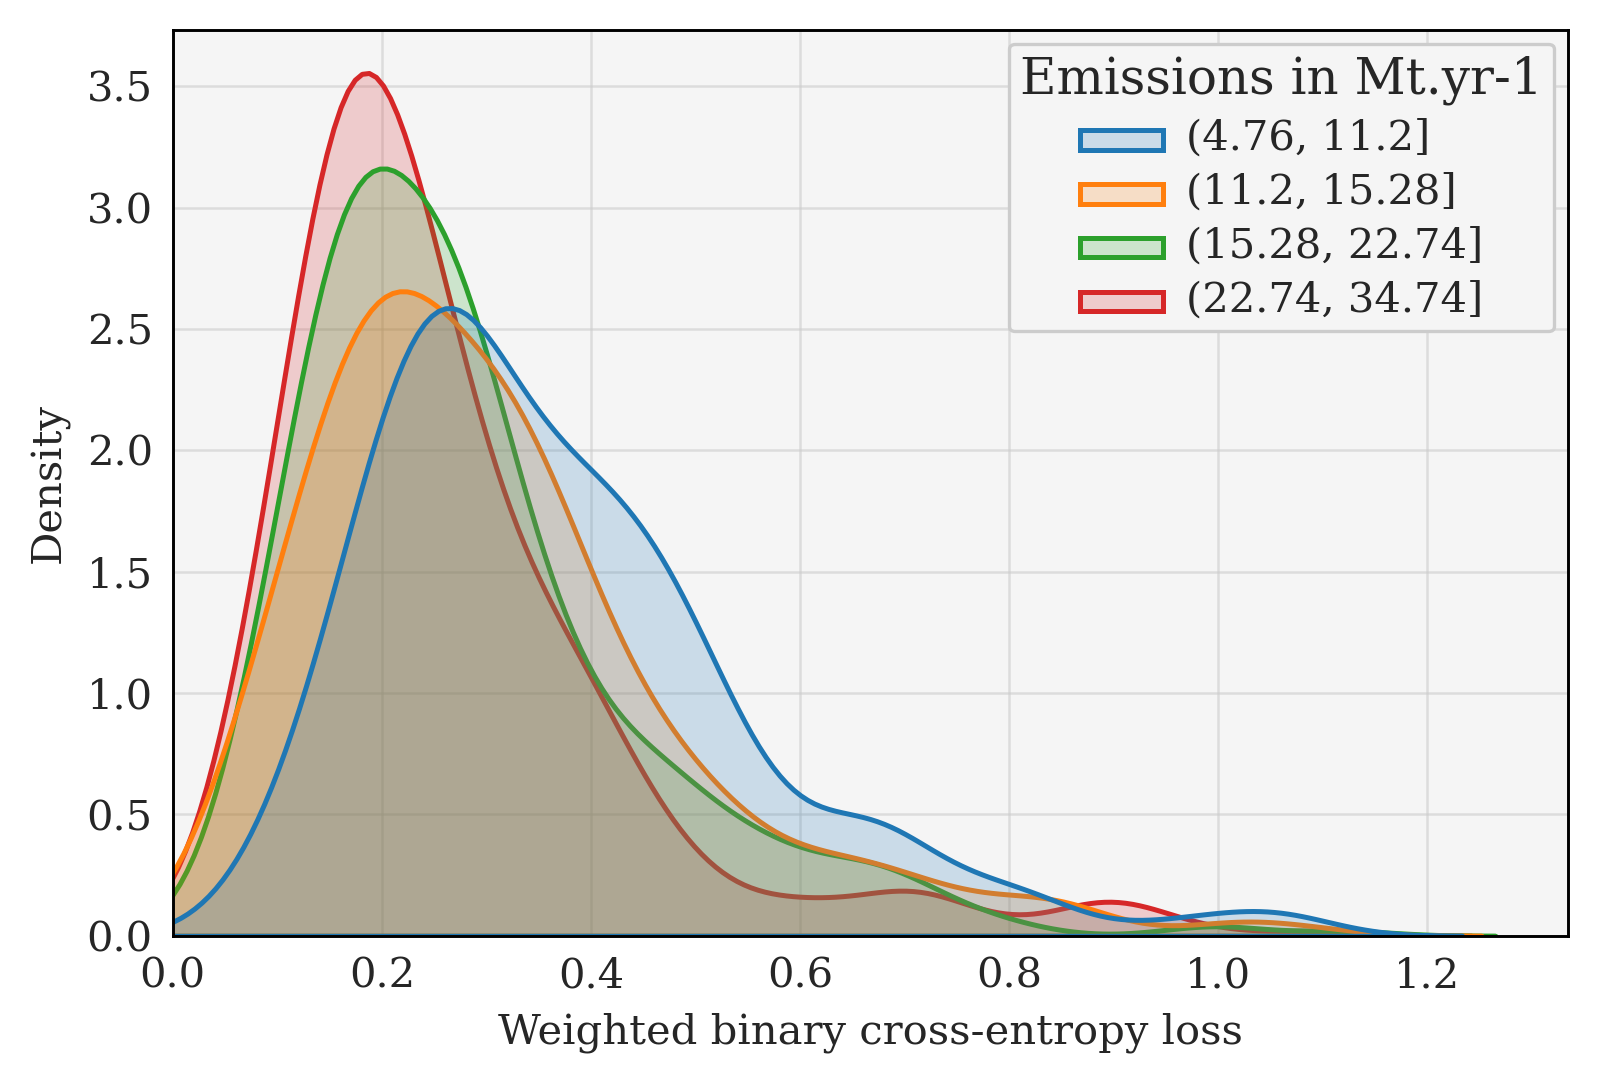

In [40]:
ax = sns.kdeplot(
    data=df,
    x="loss",
    hue="emiss",
    common_norm=False,
    fill=True,
    lw=1.2,
    alpha=0.2,
    #palette=["firebrick", "orangered", "darkolivegreen", "dodgerblue", "darkcyan"],
    #hue_order = ["Grand Paris + IDF", "Grand Paris", "Lippendorf (PP)", "Boxberg (PP)", "Janschwälde (PP)"],
)
plt.xlim(xmin=0)
plt.xlabel("Weighted binary cross-entropy loss", size=10)
plt.ylabel("Density", size=10)
plt.xticks(size=10)
plt.yticks(size=10)
ax.legend_.set_title("Emissions in Mt.yr-1")
plt.setp(ax.get_legend().get_texts(), fontsize='10')
plt.setp(ax.get_legend().get_title(), fontsize='12')
#plt.savefig(os.path.join(dir_fig, f"paper_seg_w{weights_ds}_ds{data.name_dataset}_hist_origin.png"))

In [51]:
idx0 = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))
print(model.compute_loss(y=y_valid[idx0:idx0+1], y_pred=pred_valid[idx0:idx0+1]).numpy())
ds_idx = ds_valid.isel(idx_img=idx0)
print("origin:", ds_idx.folder.values)
print("time:", ds_idx.time.values)
print("emiss:", ds_idx.emiss.values)

0.26713344
origin: smart_pBer_nBBer
time: 2015-11-11T19:00:00.000000000
emiss: [20.42424 22.36311 23.21391 23.25599 22.53739 21.31395]


In [49]:
idx1 = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))
ds_idx = ds_valid.isel(idx_img=idx1)
""""
while (ds_idx.folder.values != "smart_pBox_nBBox"):
    idx1 = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))
    ds_idx = ds_valid.isel(idx_img=idx1)
"""
print(model.compute_loss(y=y_valid[idx1:idx1+1], y_pred=pred_valid[idx1:idx1+1]).numpy())    
print("origin:", ds_idx.folder.values)
print("time:", ds_idx.time.values)
print("emiss:", ds_idx.emiss.values)


0.17586315
origin: smart_pBer_nBBer
time: 2015-01-01T22:00:00.000000000
emiss: [15.44915 22.74464 26.82981 27.61254 29.89569 30.09505]


<Figure size 1800x1200 with 0 Axes>

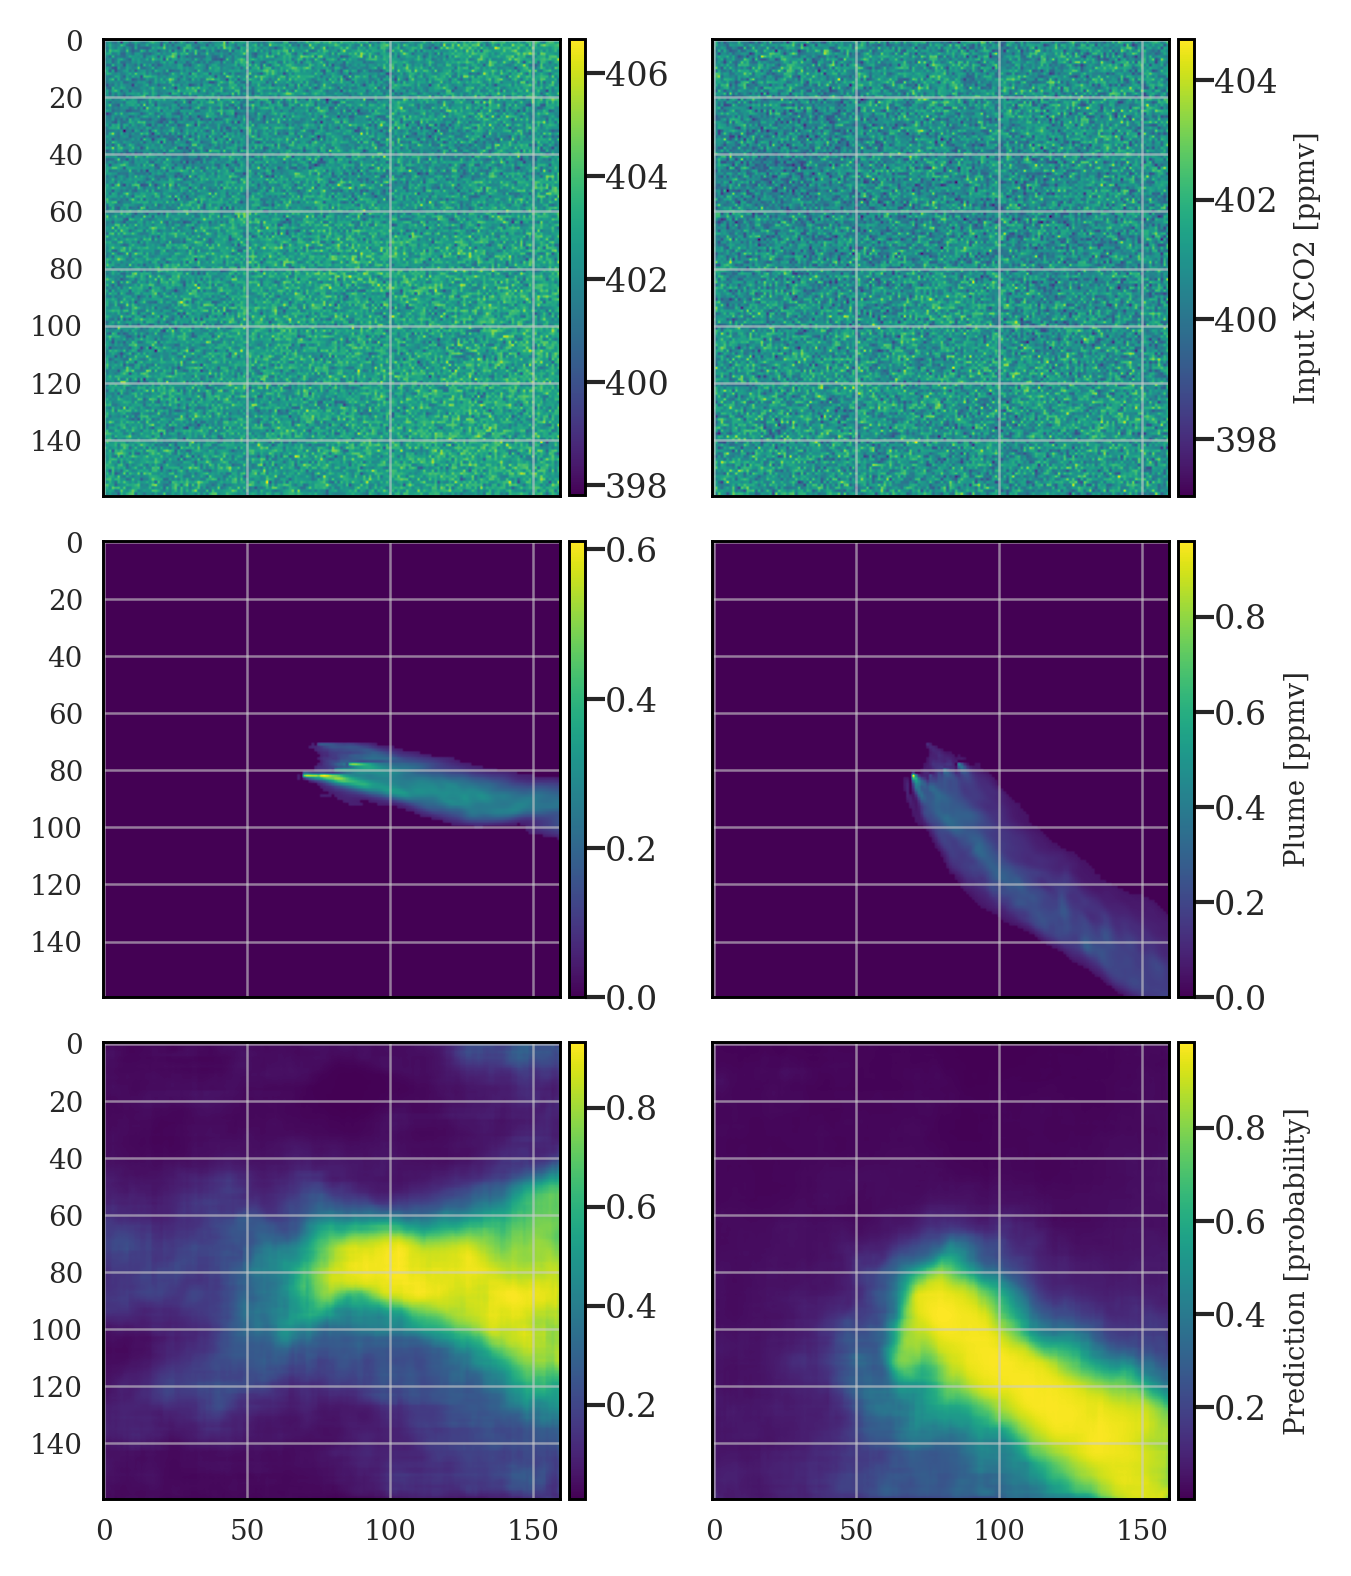

In [52]:
plt.viridis()
axs = matplotlib_functions.set_figure_axs(3, 2, wratio=0.35, hratio=0.75, pad_w_ext_left=0.25, pad_w_ext_right=0.25, pad_w_int=0.001, pad_h_ext=0.2, pad_h_int=0.15)

im0 = axs[0].imshow(scaler.inverse_transform(np.squeeze(data.x.valid[0][idx0])))
axs[0].set_xticklabels([])
cax0 = axs[0].inset_axes((1.02, 0, 0.035, 1))
cbar0 = plt.colorbar(im0, cax0, orientation="vertical")
cbar0.ax.tick_params(labelsize="8")

im1 = axs[1].imshow(scaler.inverse_transform(np.squeeze(data.x.valid[0][idx1])))
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
cax1 = axs[1].inset_axes((1.02, 0, 0.035, 1))
cbar1 = plt.colorbar(im1, cax1, orientation="vertical", label="Input XCO2 [ppmv]")
cbar1.ax.tick_params(labelsize="8")

im2 = axs[2].imshow(np.squeeze(data.y.trace_valid[idx0]))
axs[2].set_xticklabels([])
cax2 = axs[2].inset_axes((1.02, 0, 0.035, 1))
cbar2 = plt.colorbar(im2, cax2, orientation="vertical")
cbar2.ax.tick_params(labelsize="8")

im3 = axs[3].imshow(np.squeeze(data.y.trace_valid[idx1]))
axs[3].set_xticklabels([])
axs[3].set_yticklabels([])
cax3 = axs[3].inset_axes((1.02, 0, 0.035, 1))
cbar3 = plt.colorbar(im3, cax3, orientation="vertical", label="Plume [ppmv]")
cbar3.ax.tick_params(labelsize="8")

im4 = axs[4].imshow(np.squeeze(model(tf.expand_dims(data.x.valid[0][idx0], 0))[0]))
cax4 = axs[4].inset_axes((1.02, 0, 0.035, 1))
cbar4 = plt.colorbar(im4, cax4, orientation="vertical")
cbar4.ax.tick_params(labelsize="8")


im5 = axs[5].imshow(np.squeeze(model(tf.expand_dims(data.x.valid[0][idx1], 0))[0]))
axs[5].set_yticklabels([])
cax5 = axs[5].inset_axes((1.02, 0, 0.035, 1))
cbar5 = plt.colorbar(im5, cax5, orientation="vertical", label="Prediction [probability]")
cbar5.ax.tick_params(labelsize="8")

plt.savefig(os.path.join(dir_fig, f"paper_seg_w{weights_ds}_ds{data.name_dataset}_i{idx0}_i{idx1}.png"))
print(os.path.join(dir_fig, f"paper_seg_w{weights_ds}_ds{data.name_dataset}_i{idx0}_i{idx1}.png"))

In [192]:
    ax1.set_ylabel ('Density')
    ax1.text(0.05, 0.94, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
    leg = ax1.legend(loc='best', prop={'size': 4.5})
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    ax1.set_xlim (0,0.16)
    ax1.set_xlim(w_min, w_max)
    ax1.set_xticks(tcks)
    ax1.set_xticklabels(lbls)


No handles with labels found to put in legend.


NameError: name 'w_min' is not defined

In [ ]:
idx = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))
print(model.compute_loss(y=y_valid[idx:idx+1], y_pred=pred_valid[idx:idx+1]).numpy())

plt.figure()
plt.imshow(np.squeeze(data.y.trace_valid[idx]))
plt.colorbar()
plt.title("Plume")

plt.figure()
plt.imshow(np.squeeze(np.where(data.y.trace_valid[idx]>0.05,1,0)))
plt.colorbar()
plt.title("Segmentation")

plt.figure()
plt.imshow(np.squeeze(data.y.valid[idx]))
plt.colorbar()
plt.title("Truth")

plt.figure()
plt.imshow(np.squeeze(xco2_valid[idx]))
plt.colorbar()
plt.title("All fluxes")

plt.figure()
plt.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[0][idx])))
plt.colorbar()
plt.title("Input")

plt.figure()
plt.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[0][idx], 0))[0]))
plt.colorbar()
plt.title("Prediction")
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-pred.png"), transparent=True)
